In [61]:
#this code is to segregate the images which previously were not 

import os
import shutil

# Define the path to your dataset folder
dataset_path = './dataset/'

# Define the paths for the new folders
dog_folder = os.path.join(dataset_path, 'dogs')
cat_folder = os.path.join(dataset_path, 'cats')

# Create the folders if they do not exist
os.makedirs(dog_folder, exist_ok=True)
os.makedirs(cat_folder, exist_ok=True)

# Iterate through the files in the dataset folder
for filename in os.listdir(dataset_path):
    # Construct the full file path
    file_path = os.path.join(dataset_path, filename)
    
    # Check if it's a file (not a directory)
    if os.path.isfile(file_path):
        # Move the file to the appropriate folder
        if filename.startswith('dog'):
            shutil.move(file_path, os.path.join(dog_folder, filename))
        elif filename.startswith('cat'):
            shutil.move(file_path, os.path.join(cat_folder, filename))

print("Images have been separated into 'dogs' and 'cats' folders.")

Images have been separated into 'dogs' and 'cats' folders.


In [62]:
import tensorflow as tf
from tensorflow.keras import layers , models
import matplotlib.pyplot as plt

In [63]:
IMAGE_SIZE=256
BATCH_SIZE=16
CHANNELS=3
EPOCHS=10

In [64]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "dataset" ,
    shuffle=True ,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 25000 files belonging to 2 classes.


In [65]:
class_name=dataset.class_names
class_name

['cats', 'dogs']

In [66]:
len(dataset)

1563

In [67]:
for image_batch , label_batch in dataset.take(1):
    print(image_batch[0].shape)

(256, 256, 3)


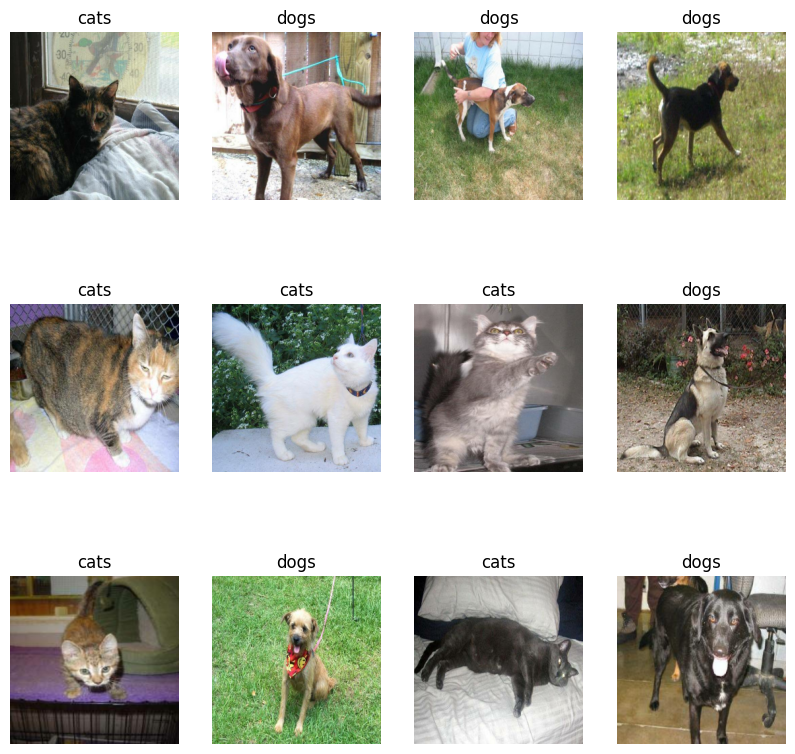

In [68]:

plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_name[labels_batch[i]])
        plt.axis("off")

In [69]:
train_size=0.8
len(dataset)*train_size

1250.4

In [70]:

train_ds=dataset.take(625)
len(train_ds)

625

In [71]:
test_ds=dataset.skip(625)
len(test_ds)

938

In [72]:

val_size=0.1
len(dataset)*val_size

156.3

In [73]:
test_ds=test_ds.skip(78)
len(test_ds)

860

In [74]:
def get_dataset_partitions_tf(ds,train_split=0.8,val_split=0.1,test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split+test_split+val_split) ==1

    ds_size=len(ds)

    if shuffle:
        ds=ds.shuffle(shuffle_size,seed=12)

    train_size=int(train_split*ds_size)
    val_size=int(val_split*ds_size)

    train_ds=ds.take(train_size)
    val_ds =ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)

    return train_ds,val_ds,test_ds

In [75]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [76]:
len(train_ds)

1250

In [77]:

len(val_ds)

156

In [78]:
len(test_ds)

157

**Cache, Shuffle, and Prefetch the Dataset**

In [79]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [80]:
resize_rescale=tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1./255)
])

In [81]:
data_augmentation=tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

In [82]:
train_ds=train_ds.map(
    lambda x,y:(data_augmentation(x , training=True),y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [83]:
tf.config.experimental.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [84]:
tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [85]:

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

Physical devices cannot be modified after being initialized


In [90]:
input_shape=(BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)

n_classes=2

model=models.Sequential([
    resize_rescale,
    #data_augmentation,
    layers.Conv2D(32,kernel_size=(3,3),activation='relu',input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu',input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(128,kernel_size=(3,3),activation='relu',input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(128,kernel_size=(3,3),activation='relu',input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(128,kernel_size=(3,3),activation='relu',input_shape=input_shape),
    layers.MaxPooling2D((2,2)),


    layers.Flatten(),
    layers.Dense(512,activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(256,activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(128,activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(n_classes , activation='sigmoid')
    
])

model.build(input_shape=input_shape)

In [91]:
model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_12 (Sequential)  (16, 256, 256, 3)         0         
                                                                 
 conv2d_52 (Conv2D)          (16, 254, 254, 32)        896       
                                                                 
 max_pooling2d_44 (MaxPoolin  (16, 127, 127, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_53 (Conv2D)          (16, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_45 (MaxPoolin  (16, 62, 62, 64)         0         
 g2D)                                                            
                                                                 
 conv2d_54 (Conv2D)          (16, 60, 60, 128)       

In [92]:
model.compile(
    optimizer='adam' , 
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [94]:
model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS,
)

Epoch 1/10
1250/1250 [==============================] - 123s 98ms/step - loss: 0.6933 - accuracy: 0.5073 - val_loss: 0.6938 - val_accuracy: 0.4868
Epoch 2/10
1250/1250 [==============================] - 124s 99ms/step - loss: 0.6935 - accuracy: 0.5028 - val_loss: 0.6934 - val_accuracy: 0.4868
Epoch 3/10
1250/1250 [==============================] - 127s 101ms/step - loss: 0.6934 - accuracy: 0.4956 - val_loss: 0.6938 - val_accuracy: 0.4868
Epoch 4/10
1250/1250 [==============================] - 124s 99ms/step - loss: 0.6932 - accuracy: 0.5068 - val_loss: 0.6928 - val_accuracy: 0.5132
Epoch 5/10
1250/1250 [==============================] - 118s 95ms/step - loss: 0.6933 - accuracy: 0.5032 - val_loss: 0.6940 - val_accuracy: 0.4868
Epoch 6/10
1250/1250 [==============================] - 126s 101ms/step - loss: 0.6933 - accuracy: 0.4954 - val_loss: 0.6940 - val_accuracy: 0.4868
Epoch 7/10
1250/1250 [==============================] - 123s 99ms/step - loss: 0.6933 - accuracy: 0.4982 - val_loss:

In [95]:
score=model.evaluate(test_ds)

157/157 [==============================] - 49s 37ms/step - loss: 0.6927 - accuracy: 0.5191
